# Cost Curve Creator

This notebook enables fitting curves to ORBIT models to create a cost function that can be
embedded in NRWAL.
A variety of curve and surface fitting options are available, and new ones can be added easily.
There are also tools for visualizing the ORBIT data and fitted curves.

## Dependencies

- ORBIT
- ipympl enables interactive matplotlib elements in jupyter notebooks via the `%matplotlib widget` magic command below

## Instructions

Follow the steps below to configure and run the notebook.

1. Create a basic ORBIT configuration file including at least the following sections:
- site
- turbine
- plant

2. Configure the notebook by setting the following variables in the "Configuration" section:
- `base_config_path`: the path to the ORBIT configuration file
- `DEPTHS`: a list of water depths to use for cost curves
- `MEAN_WIND_SPEED`: a list of mean wind speed to use for cost curves
- Add any additional global parameter ranges

3. Run the notebook to establish a first-pass fit for the ORBIT data. This will also plot the ORBIT
data and curves.

4. Refine the curve fits by swapping the curve-fit function from the options available in
the "Curve Fit Library" section

## Practical Guidance

This notebook specifically models spatially varying costs typically related to water depth
but in some cases other variables are considered. The same methods could be used to model
the cost relationship for other variables. The general workflow is to first create a parameterized
ORBIT model and obtain the cost as a function of the variables of interest.
Then, fit a curve or surface to the data by starting with the linear options.
Plot the data and curve fits to evaluate whether the linear forms are sufficient.
If not, move to the quadratic or higher order curve fits.

A class `CostFunction` is provided to simplify running the ORBIT parameterization, fit the
curves to the data, and visualize the results. An example is given below to instantiate the
class:
```python
cost_function = CostFunction(
    config={"design_phases": ["MonopileDesign"]},
    parameters={
        "site.depth": DEPTHS,
        "site.mean_windspeed": MEAN_WIND_SPEED,
    },
    results={
        "monopile_unit_cost": lambda run: run.design_results["monopile"]["unit_cost"],
    }
)
```

The config parameter is a dictionary containing additional configuration parameters to add to
the basic ORBIT configuration provided through the input file created in Step 1 in the instructions.
Any parameters given in the `CostFunction` config will be added to the base configuration or
overwritten if they already exist. The parameters dictionary contains the variables to be varied
in the cost function via `ORBIT.ParametricManager`, and the results dictionary sets the results
variables from ORBIT. Each of these dictionaries are passed directly to the
`ORBIT.ParametricManager` class.

The fitted curves are saved on the `CostFunction` object and multiple types can exist at the
same time. Two versions of one type cannot be saved at the same time. To create a curve fit,
call one of the curve fit methods on the `CostFunction` instance. Then, an attribute is saved
on the instance with the curve fit type.

Considerations:
- The `CostFunction` class supports parameterizations of at-most 2 variables.
- One instance of the `CostFunction` class can be used to fit multiple curves for a single
    cost model.
- A new `CostFunction` instance should be created for each cost model.

## Template workflow

The following code block provides a template for creating a cost function for a model with
two independent parameters.

```python

# Create the CostFunction object with the ORBIT configuration for the parameterization
cost_function = CostFunction(
    config={
        "design_phases": ["Design"],
    },
    parameters={
        "site.depth": DEPTHS,
        "site.mean_windspeed": MEAN_WIND_SPEED,
    },
    results={
        "system_cost": lambda run: run.design_results["system"]["system_cost"],
    }
)

# Run ORBIT via ORBIT.ParametricManager
cost_function.run()

# Fit two curves (surfaces since there are two independent parameters) to the data.
# After running the following two commands, the CostFunction object will have two related
# attributes that store the curve fits.
cost_function.fit_curve("linear_2d")
cost_function.fit_curve("quadratic_2d")

# Plot the data and curves
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Depth vs mean wind speed")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Mean wind speed (m/s)")
ax.set_zlabel("Cost ($)")
cost_function.plot(ax, plot_data=True)
cost_function.plot(ax, plot_curves=["linear_1d", "quadratic_1d"])   # These curves must have been generated first
# alternatively, the two lines above could be combined into a single line:
# cost_function.plot(ax, plot_data=True, plot_curves=["linear_1d", "quadratic_1d"])
```

## Plotting API for 2D vs 3D plots
The `CostFunction` class handles 2D and 3D data seamlessly by using the x and z parameters for 2D
and adding y for 3D. The appropriate matplotlib API is used depending if the data is 2D or 3D.
From the calling script, be sure to configure the Axes that is given to `CostFunction.plot` with
the correct settings for 3D as listed in the table below.

| Matplotlib setting | 2D | 3D |
|---------------------|----|----|
| Independent axis labels | `ax.set_xlabel()`  | `ax.set_xlabel()`, `ax.set_zlabel()` |
| Dependent axis label | `ax.set_ylabel()` | `ax.set_zlabel()` |

In [1]:
%matplotlib widget

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats, optimize, linalg

from ORBIT import (
    ParametricManager,
    load_config,
)

## Configuration

Replace any of these throughout the notebook to customize a cost model parameterization.

In [2]:
base_config_path = "nrwal.yaml"
base_config = load_config(base_config_path)

DEPTHS = [i for i in range(5, 60, 5)]           # Ocean depth in meters
MEAN_WIND_SPEED = [i for i in range(2, 20, 2)]  # Mean wind speed in m/s

## Curve Fit Library

These functions enable fitting a curve to a set of points based on a variety of curve shapes.
They should always be generic, so the global variables should not be used here.

In [3]:
class Curves():
    """
    This class contains static methods for fitting data to various curve types.
    Though they could exist outside of a class, consolidating them into a consistent
    namespace allows for a simpler API throughout the script.
    """

    @staticmethod
    def polynomial_eval(coeffs, data_points):
        """
        This method evaluates a curve given a set of coefficients and data points.

        Args:
            coeffs (list): A list of coefficients for the curve. The order of the
                coefficients should be from highest to lowest power.
            data_points (list): A list of data points at which to evaluate the curve.

        Returns:
            np.array: The curve evaluated at the given data points.
        """
        curve = np.zeros_like(data_points)
        for i, dp in enumerate(data_points):

            # This loop sums the terms of the polynomial
            for j in range(len(coeffs)):
                curve[i] += coeffs[j] * (dp ** (len(coeffs) - 1 - j))
        return curve

    @staticmethod
    def fit(func, x, y, fit_check=False):
        if x is pd.Series:
            x = x.to_numpy(dtype=np.float64)
        elif x is np.array:
            x = x.astype(np.float64)
        if y is pd.Series:
            y = y.to_numpy(dtype=np.float64)
        elif y is np.array:
            y = y.astype(np.float64)

        popt, pcov, nfodict, mesg, ier = optimize.curve_fit(func, x, y, full_output=True)

        if fit_check:
            print(f"mesg: {mesg}")
            print(f"ier: {ier}")
            print(f"Coefficients: {popt}")
            # print(f"R-squared: {rvalue**2:.6f}")
        
        return popt

In [4]:
class CostFunction():
    """
    This class is used to create the ORBIT parameterization, fit a curve, plot the curve, and
    export the function to NRWAL format.
    Use of this function is limited to parameterizations that include `site.depth` and up to
    one other parameter.
    """
    def __init__(self, config: dict, parameters: dict, results: dict):
        """
        _summary_

        Args:
            config (str): Configuration settings to added to the base_config or overwrite
                in the base_config. This must include the `design_phases` config.
            parameters (dict): Parameters to use with ORBIT.ParametricManager; maximum of two
                parameters are supported.
            results (dict): Results to use with ORBIT.ParametricManager; this must include only
                one variable.
        """
        self.is_3d = False

        # NOTE: base_config is a global variable
        self.config = deepcopy(base_config)
        self.config.update(config)

        self.parameters = deepcopy(parameters)
        if len(self.parameters) > 2:
            raise ValueError("This class is limited to parameterizations with one variable in addition to site.depth")

        # Puts the parameters and results settings into variables for use in parsing the ORBIT
        # results and postprocessing the data
        self.parameters = deepcopy(self.parameters)
        _vars = list(self.parameters.keys())
        self.x_variable = _vars.pop(0)          # NOTE: This assumes the first parameter is site.depth; it's not critical to functionality but good to keep in mind
        if len(_vars) == 1:
            self.is_3d = True
            self.y_variable = _vars.pop()
        self.z_variable = list(results.keys())[0]

        self.results = deepcopy(results)
        if len(results) != 1:
            raise ValueError("This class is limited to results with one variable")

    def run(self):
        self.parametric = ParametricManager(self.config, self.parameters, self.results, product=True)
        self.parametric.run()

        self.x = self.parametric.results[self.x_variable]
        if self.is_3d:
            self.y = self.parametric.results[self.y_variable]
        self.z = self.parametric.results[self.z_variable]


    ### --------- Curve fit functions --------- ###

    def linear_1d(self):
        def f(x, a, b):
            return a * x + b
        coeffs = Curves.fit(f, self.x, self.z)
        self._linear_1d_curve = Curves.polynomial_eval(coeffs, self.x)

    def quadratic_1d(self):
        def f(x, a, b, c):
            return a * x**2 + b * x + c
        coeffs = Curves.fit(f, self.x, self.z)
        self._quadratic_1d_curve = Curves.polynomial_eval(coeffs, self.x)

    def poly3_1d(self):
        def f(x, a, b, c, d):
            return a * x**3 + b * x**2 + c * x + d
        coeffs = Curves.fit(f, self.x, self.z)
        self._poly3_1d_curve = Curves.polynomial_eval(coeffs, self.x)

    def logarithmic_1d(self):
        pass

    def exponential_1d(self):
        pass

    def linear_2d(self):
        data_to_fit = np.array(list(zip(self.x, self.y, self.z)))

        # Best-fit linear plane
        A = np.c_[data_to_fit[:,0], data_to_fit[:,1], np.ones(data_to_fit.shape[0])]
        C,_,_,_ = linalg.lstsq(A, data_to_fit[:,2])    # coefficients

        # Evaluate it on the same points as the input data
        self._linear_2d_curve = C[0]*self.x + C[1]*self.y + C[2]

    def quadratic_2d(self):
        """
        Fits a quadratic surface to the data points.
        x and y are the independent variables, and data is the dependent variable.
        Each of the arguments should be given directly from ORBIT and they are transformed
        here into the required form for use with the curve fitting library.
        """
        data_to_fit = np.array(list(zip(self.x, self.y, self.z)))

        # best-fit quadratic curve
        A = np.c_[
            np.ones(data_to_fit.shape[0]),
            data_to_fit[:,:2],
            np.prod(data_to_fit[:,:2], axis=1),
            data_to_fit[:,:2]**2
        ]
        C,_,_,_ = linalg.lstsq(A, data_to_fit[:,2])

        # Evaluate it on the same points as the input data
        # This dot product is equivalent to the sum of the terms of the polynomial;
        # np.c_[] is used to concatenate the arrays into the correct form for the dot product
        # and C is the coefficients of the polynomial
        self._quadratic_2d_curve = np.dot(
            np.c_[
                np.ones(self.x.shape),
                self.x,
                self.y,
                self.x*self.y,
                self.x**2,
                self.y**2
            ],
            C
        ).reshape(self.x.shape)


    ### --------- Plotting functions --------- ###

    def plot(
        self,
        ax,
        plot_data: bool = False,
        plot_curves: list[str] = []
    ):
        if plot_data:
            if self.is_3d:
                ax.scatter(self.x, self.y, zs=self.z, zdir='z', label="Data")
            else:
                ax.scatter(self.x, self.z, label="Data")

        for curve in plot_curves:

            if curve == "linear_1d":
                ax.plot(self.x, self._linear_1d_curve, label="Linear Fit")

            if curve == "quadratic_1d":
                ax.plot(self.x, self._quadratic_1d_curve, label="Quadratic Fit")

            if curve == "poly3_1d":
                ax.plot(self.x, self._poly3_1d_curve, label="Degree 3 Polynomial Fit")

            if curve == "linear_2d":
                ax.plot_surface(
                    np.reshape(self.x, (len(DEPTHS), -1)),
                    np.reshape(self.y, (len(DEPTHS), -1)),
                    np.reshape(self._linear_2d_curve, (len(DEPTHS), -1)),
                    alpha=0.3,
                    label="Linear Fit"
                )

            if curve == "quadratic_2d":
                ax.plot_surface(
                    np.reshape(self.x, (len(DEPTHS), -1)),
                    np.reshape(self.y, (len(DEPTHS), -1)),
                    np.reshape(self._quadratic_2d_curve, (len(DEPTHS), -1)),
                    alpha=0.3,
                    label="Quadratic Fit"
                )

# ORBIT Design Phase Cost Curves

## Monopile Substructure

Independent variables:
- Water depth: impacts the mass of the monopile since it is fixed to the ocean floor
- Mean wind speed: impact the mass of the monopile by the load transferred from the turbine

ORBIT library intialized at '/Users/rmudafor/Development/orbit/library'


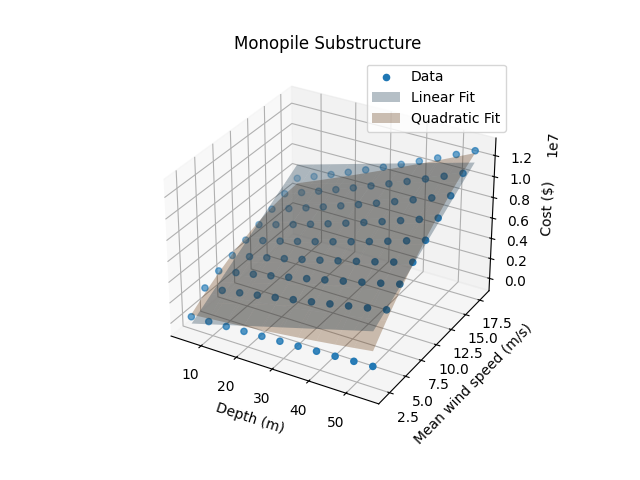

In [5]:
cost_function = CostFunction(
    config={"design_phases": ["MonopileDesign"]},
    parameters={
        "site.depth": DEPTHS,
        "site.mean_windspeed": MEAN_WIND_SPEED,
    },
    results={
        "monopile_unit_cost": lambda run: run.design_results["monopile"]["unit_cost"],
        # "transition_piece_unit_cost": lambda run: run.design_results["transition_piece"]["unit_cost"],
    }
)
cost_function.run()

cost_function.linear_2d()
cost_function.quadratic_2d()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Monopile Substructure")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Mean wind speed (m/s)")
ax.set_zlabel("Cost ($)")
cost_function.plot(ax, plot_data=True)
cost_function.plot(ax, plot_curves=["linear_2d", "quadratic_2d"])
ax.legend()

## Semi-Submersible Substructure

Since the semisubmersible is a floating structure, the water depth does not impact the mass
of the structure.
The mean wind speed does impact the mass of the structure by the load transferred from the
turbine, but this is not included in the design phase cost model directly.
The plot here shows that the cost is constant with respect to the water depth.

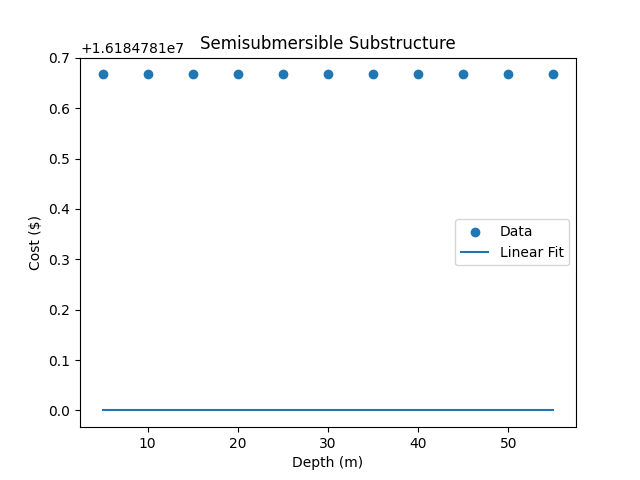

In [6]:
cost_function = CostFunction(
    config={"design_phases": ["SemiSubmersibleDesign"]},
    parameters={
        "site.depth": DEPTHS,
    },
    results={
        "substructure_unit_cost": lambda run: run.design_results["substructure"]["unit_cost"],
    }
)
cost_function.run()

cost_function.linear_1d()

fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Semisubmersible Substructure")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Cost ($)")
cost_function.plot(ax, plot_data=True)
cost_function.plot(ax, plot_curves=["linear_1d"])
ax.legend()

## Mooring System

For all types, the line length is a function of water depth.

For TLP systems, line length is the difference between the water depth and the draft.

For SemiTaut systems, line length is the sum of rope length and chain length.
Rope length is defined from a fixed relationship for depth and rope lengths.
Chain length is also defined from a fixed relationship for depth and chain diameter.
While the semi-taut system line length is dependent on rope length and chain length, the parameters
are fixed and depend on water depth so they are not included in this parameterization.

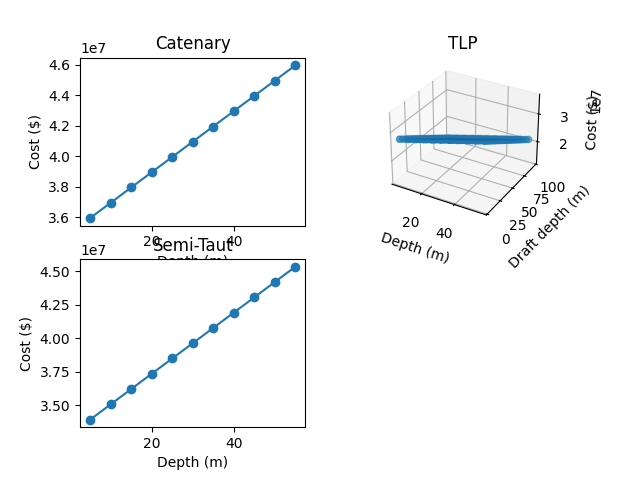

In [7]:
design_phase = "MooringSystemDesign"
results = {
    "mooring_system_system_cost": lambda run: run.design_results["mooring_system"]["system_cost"],
}

# Catenary mooring system
cost_catenary = CostFunction(
    config={
        "design_phases": [design_phase],
        "mooring_system_design": {"mooring_type": "Catenary"}
    },
    parameters={
        "site.depth": DEPTHS,
    },
    results=results
)
cost_catenary.run()

# Tension Leg Platform (TLP) mooring system
cost_tlp = CostFunction(
    config={
        "design_phases": [design_phase],
        "mooring_system_design": {"mooring_type": "TLP"}
    },
    parameters={
        "site.depth": DEPTHS,
        "mooring_system_design.draft_depth": [i for i in range(5, 100, 5)] # Draft depth 5-100 meters
    },
    results=results
)
cost_tlp.run()

# Semi-taut mooring system
cost_semitaut = CostFunction(
    config={
        "design_phases": [design_phase],
        "mooring_system_design": {"mooring_type": "SemiTaut"}
    },
    parameters={
        "site.depth": DEPTHS,
    },
    results=results
)
cost_semitaut.run()

## Fit the data to a curve
cost_catenary.linear_1d()
cost_tlp.linear_2d()
cost_semitaut.linear_1d()

## Plot the ORBIT data and curve fits

fig = plt.figure()

ax = fig.add_subplot(2, 2, 1)
ax.set_title("Catenary")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Cost ($)")
cost_catenary.plot(ax, plot_data=True)
cost_catenary.plot(ax, plot_curves=["linear_1d"])

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title("TLP")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Draft depth (m)")
ax.set_zlabel("Cost ($)")
cost_tlp.plot(ax, plot_data=True)
cost_tlp.plot(ax, plot_curves=["linear_2d"])

ax = fig.add_subplot(2, 2, 3)
ax.set_title("Semi-Taut")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Cost ($)")
cost_semitaut.plot(ax, plot_data=True)
cost_semitaut.plot(ax, plot_curves=["linear_1d"])

## Array System

The array system cost is entirely dependent on the cable length.
The cable length is a function of some fixed plant parameters and the following spatially
dependent parameters:
- water depth
- touchdown distance
- floating cable depth

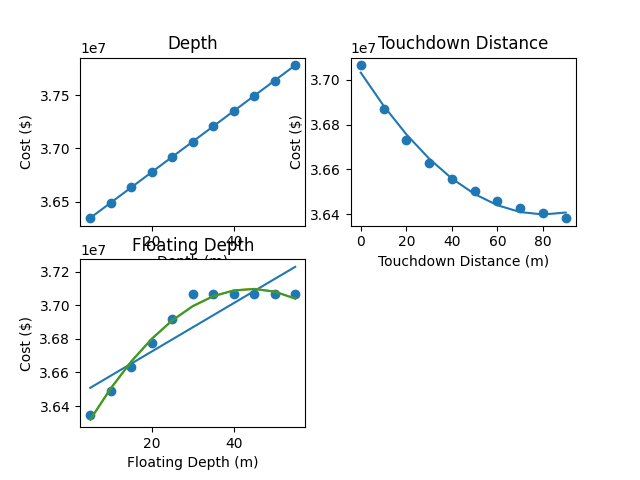

In [8]:
# First plot cost as a function of depth, touchdown_distance, and floating_cable_depth to get a
# sense for the 1d relationships

design_phase = "ArraySystemDesign"
results = {
    "array_system_system_cost": lambda run: run.design_results["array_system"]["system_cost"],
}

# Water depth
cost_depth = CostFunction(
    config={
        "design_phases": [design_phase],
    },
    parameters={
        "site.depth": DEPTHS,
    },
    results=results
)
cost_depth.run()

# Touchdown distance
cost_touchdown_distance = CostFunction(
    config={
        "design_phases": [design_phase],
    },
    parameters={
        "array_system_design.touchdown_distance": [i for i in range(0, 100, 10)],
    },
    results=results
)
cost_touchdown_distance.run()

# Floating cable depth
cost_cable_depth = CostFunction(
    config={
        "design_phases": [design_phase],
    },
    parameters={
        "array_system_design.floating_cable_depth": DEPTHS,
    },
    results=results
)
cost_cable_depth.run()

cost_depth.linear_1d()
cost_touchdown_distance.quadratic_1d()
cost_cable_depth.linear_1d()
cost_cable_depth.quadratic_1d()
cost_cable_depth.poly3_1d()

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title("Depth")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Cost ($)")
cost_depth.plot(ax, plot_data=True)
cost_depth.plot(ax, plot_curves=["linear_1d"])

ax = fig.add_subplot(2, 2, 2)
ax.set_title("Touchdown Distance")
ax.set_xlabel("Touchdown Distance (m)")
ax.set_ylabel("Cost ($)")
cost_touchdown_distance.plot(ax, plot_data=True)
cost_touchdown_distance.plot(ax, plot_curves=["quadratic_1d"])

ax = fig.add_subplot(2, 2, 3)
ax.set_title("Floating Depth")
ax.set_xlabel("Floating Depth (m)")
ax.set_ylabel("Cost ($)")
cost_cable_depth.plot(ax, plot_data=True)
cost_cable_depth.plot(ax, plot_curves=["linear_1d", "quadratic_1d", "poly3_1d"])

In [9]:
# Then create functions of two variables

design_phase = "ArraySystemDesign"
results = {
    "array_system_system_cost": lambda run: run.design_results["array_system"]["system_cost"],
}

# Water depth vs touchdown distance
cost_depth_touchdown_distance = CostFunction(
    config={
        "design_phases": [design_phase],
    },
    parameters={
        "site.depth": DEPTHS,
        "array_system_design.touchdown_distance": [i for i in range(0, 100, 10)],
    },
    results=results
)
cost_depth_touchdown_distance.run()

# Water depth vs cable depth
cost_depth_cabledepth = CostFunction(
    config={
        "design_phases": [design_phase],
    },
    parameters={
        "site.depth": DEPTHS,
        "array_system_design.floating_cable_depth": DEPTHS,
    },
    results=results
)
cost_depth_cabledepth.run()

# Touchdown distance vs cable depth
cost_touchdown_cabledepth = CostFunction(
    config={
        "design_phases": [design_phase],
    },
    parameters={
        "array_system_design.floating_cable_depth": DEPTHS,
        "array_system_design.touchdown_distance": [i for i in range(0, 100, 10)],
    },
    results=results
)
cost_touchdown_cabledepth.run()

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.RuntimeWarning: /Users/rmudafor/Development/orbit/ORBIT/phases/design/_cables.py:386
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

overflow encountered in cosh

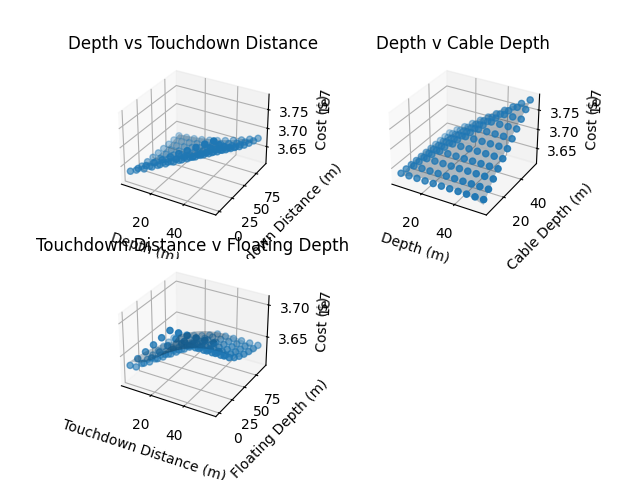

In [10]:
cost_depth_touchdown_distance.quadratic_2d()
cost_depth_cabledepth.quadratic_2d()
cost_touchdown_cabledepth.quadratic_2d()

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title("Depth vs Touchdown Distance")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Touchdown Distance (m)")
ax.set_zlabel("Cost ($)")
cost_depth_touchdown_distance.plot(ax, plot_data=True)
cost_depth_touchdown_distance.plot(ax, plot_curves=["quadratic_2d"])

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title("Depth v Cable Depth")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Cable Depth (m)")
ax.set_zlabel("Cost ($)")
cost_depth_cabledepth.plot(ax, plot_data=True)
cost_depth_cabledepth.plot(ax, plot_curves=["quadratic_2d"])

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_title("Touchdown Distance v Floating Depth")
ax.set_xlabel("Touchdown Distance (m)")
ax.set_ylabel("Floating Depth (m)")
ax.set_zlabel("Cost ($)")
cost_touchdown_cabledepth.plot(ax, plot_data=True)
cost_touchdown_cabledepth.plot(ax, plot_curves=["quadratic_2d"])

## Export System
- site.distance_to_landfall
- Here, we must use parametric.results["site.depth"] instead of the global DEPTHS because the
- local depth list is broadcast to 2D for the product of the two lists.
- Plot curves for HVAC and HVDC cable types

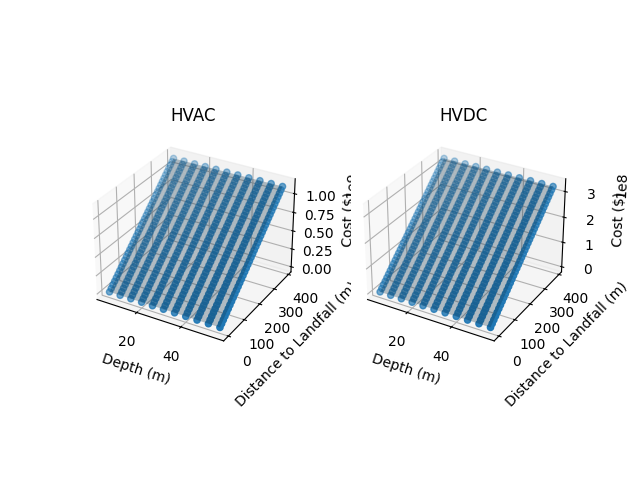

In [11]:
design_phase = "ExportSystemDesign"
results = {
    "export_system_system_cost": lambda run: run.design_results["export_system"]["system_cost"],
}

## Run ORBIT for each hvac and hvdc export system types

cost_hvac = CostFunction(
    config={
        "design_phases": [design_phase],
        "export_system_design": {"cables": "XLPE_1000mm_220kV"},
    },
    parameters={
        "site.depth": DEPTHS,
        "site.distance_to_landfall": [i for i in range(0, 400, 10)],
    },
    results=results
)
cost_hvac.run()

cost_hvdc = CostFunction(
    config={
        "design_phases": [design_phase],
        "export_system_design": {"cables": "HVDC_2000mm_320kV"},
    },
    parameters={
        "site.depth": DEPTHS,
        "site.distance_to_landfall": [i for i in range(0, 400, 10)],
    },
    results=results
)
cost_hvdc.run()

cost_hvac.linear_2d()
cost_hvdc.linear_2d()

## Plot the ORBIT data and curve fits

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("HVAC")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Distance to Landfall (m)")
ax.set_zlabel("Cost ($)")
cost_hvac.plot(ax, plot_data=True)
cost_hvac.plot(ax, plot_curves=["linear_2d"])

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("HVDC")
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Distance to Landfall (m)")
ax.set_zlabel("Cost ($)")
cost_hvdc.plot(ax, plot_data=True)
cost_hvdc.plot(ax, plot_curves=["linear_2d"])